In [15]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
LEARNING_RATE = 0.0001
# train_ds, val_ds, label_names = dataset_tf("./dataset/osbh_pure", 0.2, 16)
train_ds, val_ds, label_names = dataset_tf("dataset/osbh_sep_2", 0.4, 8)

Found 900 files belonging to 2 classes.
Using 540 files for training.
Using 360 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (8, 4000)
Example label shape: (8,)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [16]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Initial models (OSBH)

## MFCCs

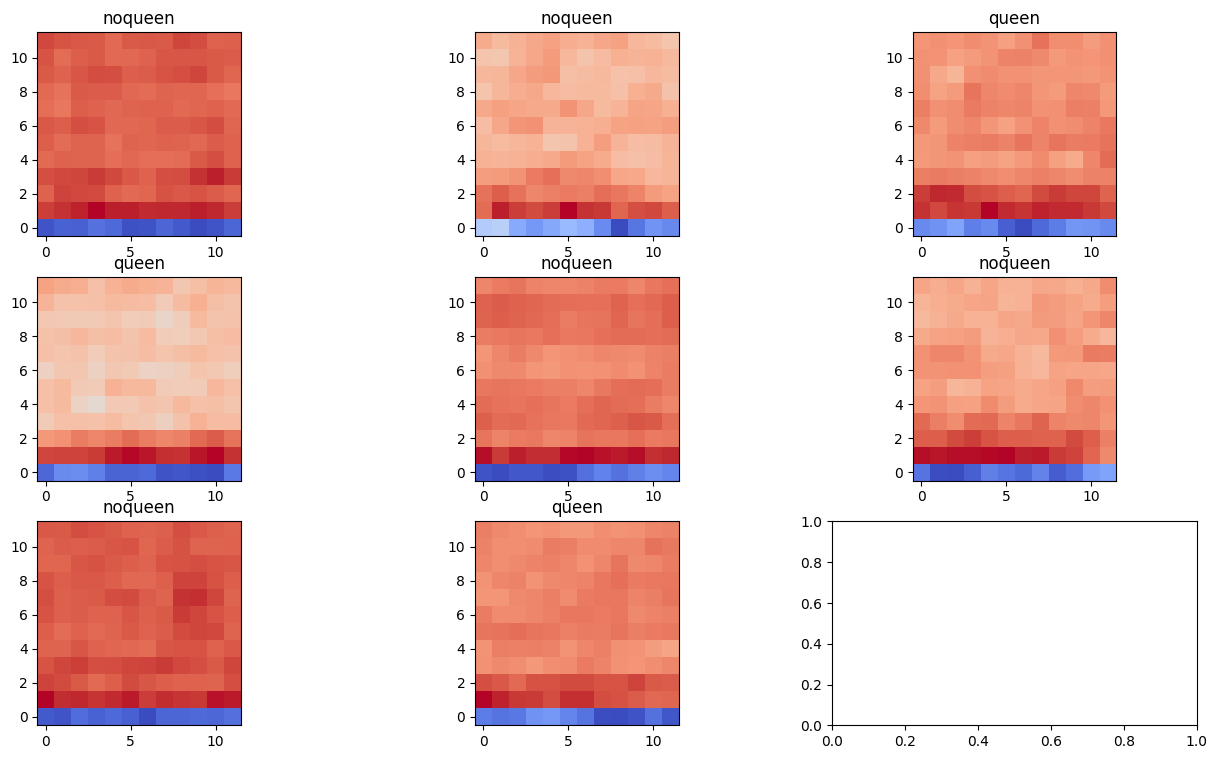

In [17]:
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
plot_mfccs(example_spectrograms, example_spect_labels, label_names)

In [18]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [19]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [MFCCs] Sequential model

Epoch 1/20


2024-03-30 17:31:46.222875: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


68/68 [==============================] - 2s 20ms/step - loss: 0.6265 - accuracy: 0.6444 - val_loss: 0.5714 - val_accuracy: 0.6167
Epoch 2/20
68/68 [==============================] - 1s 14ms/step - loss: 0.4832 - accuracy: 0.7704 - val_loss: 0.4573 - val_accuracy: 0.7056
Epoch 3/20
68/68 [==============================] - 1s 14ms/step - loss: 0.3462 - accuracy: 0.8944 - val_loss: 0.3413 - val_accuracy: 0.8611
Epoch 4/20
68/68 [==============================] - 1s 14ms/step - loss: 0.3071 - accuracy: 0.8926 - val_loss: 0.2901 - val_accuracy: 0.9000
Epoch 5/20
68/68 [==============================] - 1s 13ms/step - loss: 0.2698 - accuracy: 0.9241 - val_loss: 0.2561 - val_accuracy: 0.9056
Epoch 6/20
68/68 [==============================] - 1s 13ms/step - loss: 0.2478 - accuracy: 0.9333 - val_loss: 0.2536 - val_accuracy: 0.9139
Epoch 7/20
68/68 [==============================] - 1s 13ms/step - loss: 0.2329 - accuracy: 0.9370 - val_loss: 0.2289 - val_accuracy: 0.9278
Epoch 8/20
68/68 [======

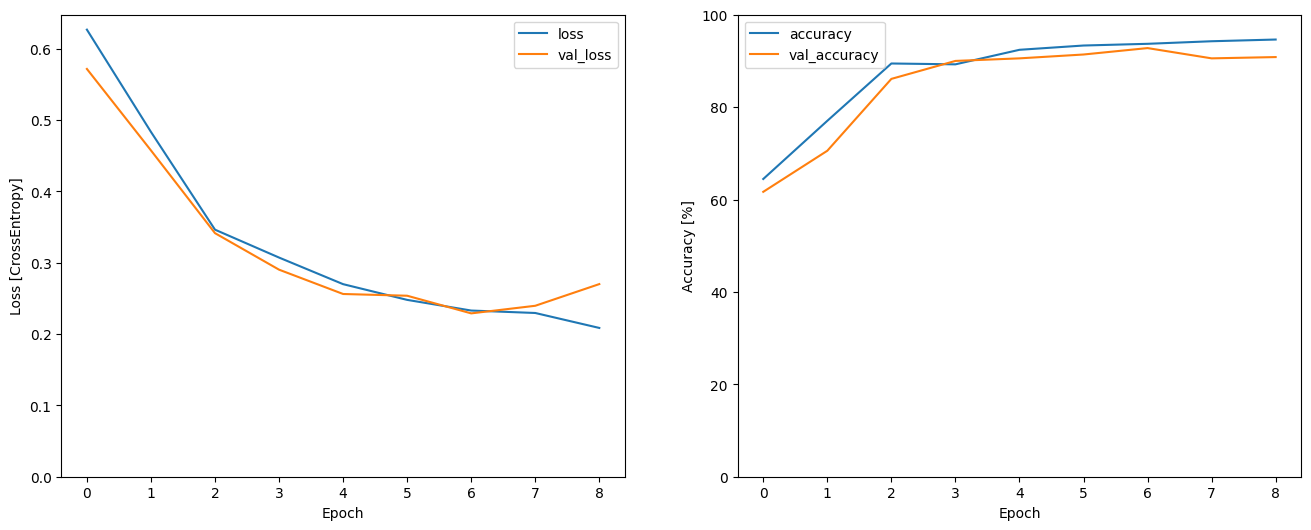

In [20]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [MFCCs] Convolutional model (mini)

Epoch 1/20
68/68 [==============================] - 1s 9ms/step - loss: 0.6436 - accuracy: 0.6611 - val_loss: 0.5936 - val_accuracy: 0.6306
Epoch 2/20
68/68 [==============================] - 0s 6ms/step - loss: 0.5727 - accuracy: 0.6870 - val_loss: 0.5267 - val_accuracy: 0.7778
Epoch 3/20
68/68 [==============================] - 0s 6ms/step - loss: 0.5078 - accuracy: 0.7704 - val_loss: 0.4643 - val_accuracy: 0.8444
Epoch 4/20
68/68 [==============================] - 0s 7ms/step - loss: 0.4596 - accuracy: 0.8463 - val_loss: 0.4084 - val_accuracy: 0.8472
Epoch 5/20
68/68 [==============================] - 0s 6ms/step - loss: 0.4188 - accuracy: 0.8593 - val_loss: 0.3675 - val_accuracy: 0.8694
Epoch 6/20
68/68 [==============================] - 0s 7ms/step - loss: 0.3779 - accuracy: 0.8815 - val_loss: 0.3389 - val_accuracy: 0.8778
Epoch 7/20
68/68 [==============================] - 0s 7ms/step - loss: 0.3499 - accuracy: 0.9019 - val_loss: 0.3134 - val_accuracy: 0.8833
Epoch 8/20
68/68 [==

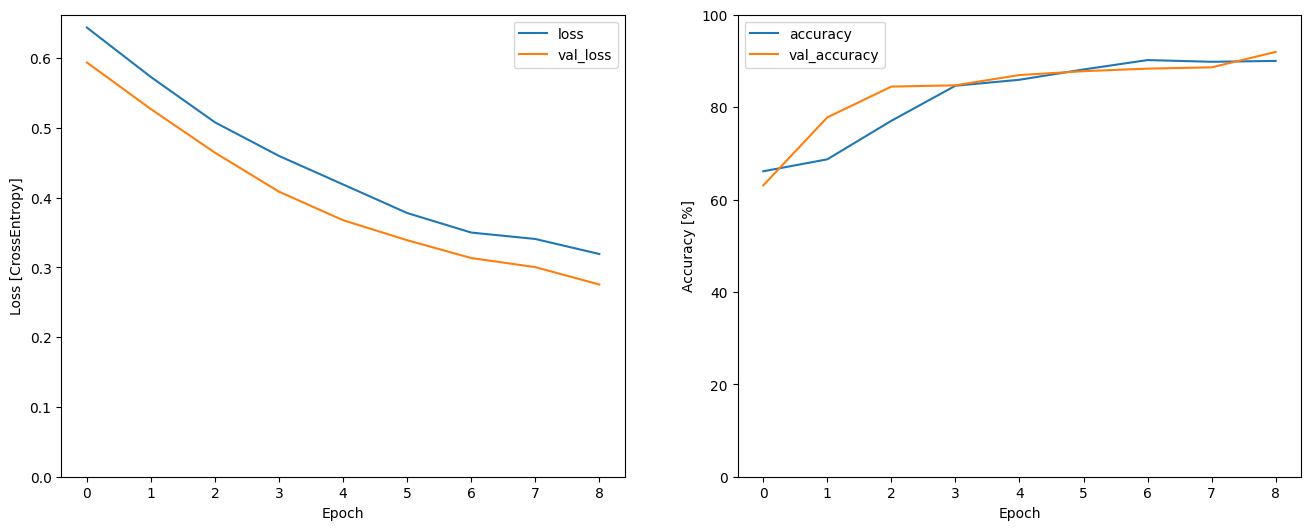

In [21]:
model_mfcc_conv = get_conv_model(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Spectrograms

(118, 129, 1)


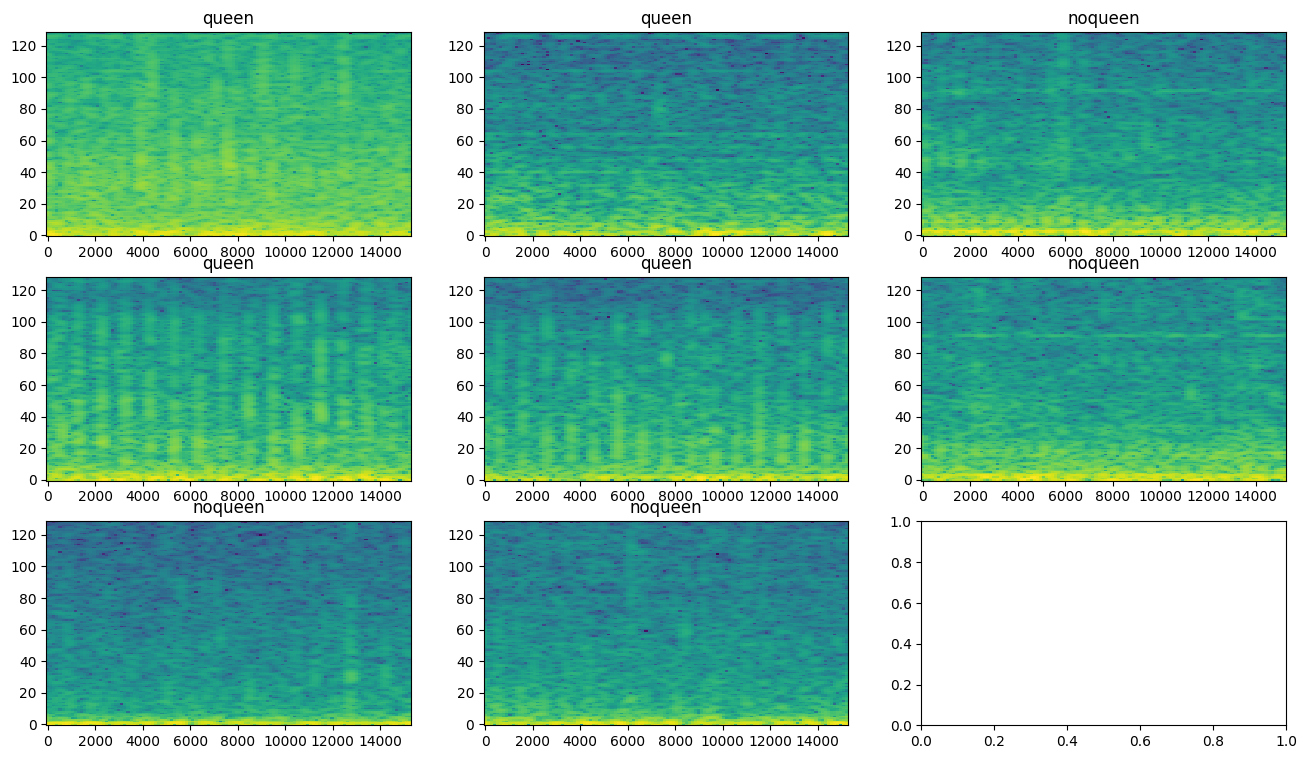

In [22]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [23]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Spec] Sequential model

Epoch 1/20
68/68 [==============================] - 2s 17ms/step - loss: 0.6482 - accuracy: 0.5907 - val_loss: 0.6264 - val_accuracy: 0.6167
Epoch 2/20
68/68 [==============================] - 1s 13ms/step - loss: 0.6064 - accuracy: 0.6426 - val_loss: 0.5976 - val_accuracy: 0.6528
Epoch 3/20
68/68 [==============================] - 1s 13ms/step - loss: 0.5574 - accuracy: 0.6870 - val_loss: 0.5414 - val_accuracy: 0.7611
Epoch 4/20
68/68 [==============================] - 1s 13ms/step - loss: 0.4852 - accuracy: 0.7722 - val_loss: 0.4857 - val_accuracy: 0.6944
Epoch 5/20
68/68 [==============================] - 1s 13ms/step - loss: 0.4311 - accuracy: 0.8167 - val_loss: 0.4057 - val_accuracy: 0.8750
Epoch 6/20
68/68 [==============================] - 1s 13ms/step - loss: 0.3817 - accuracy: 0.8556 - val_loss: 0.3785 - val_accuracy: 0.8917
Epoch 7/20
68/68 [==============================] - 1s 13ms/step - loss: 0.3405 - accuracy: 0.8574 - val_loss: 0.3251 - val_accuracy: 0.9111
Epoch 8/20
68

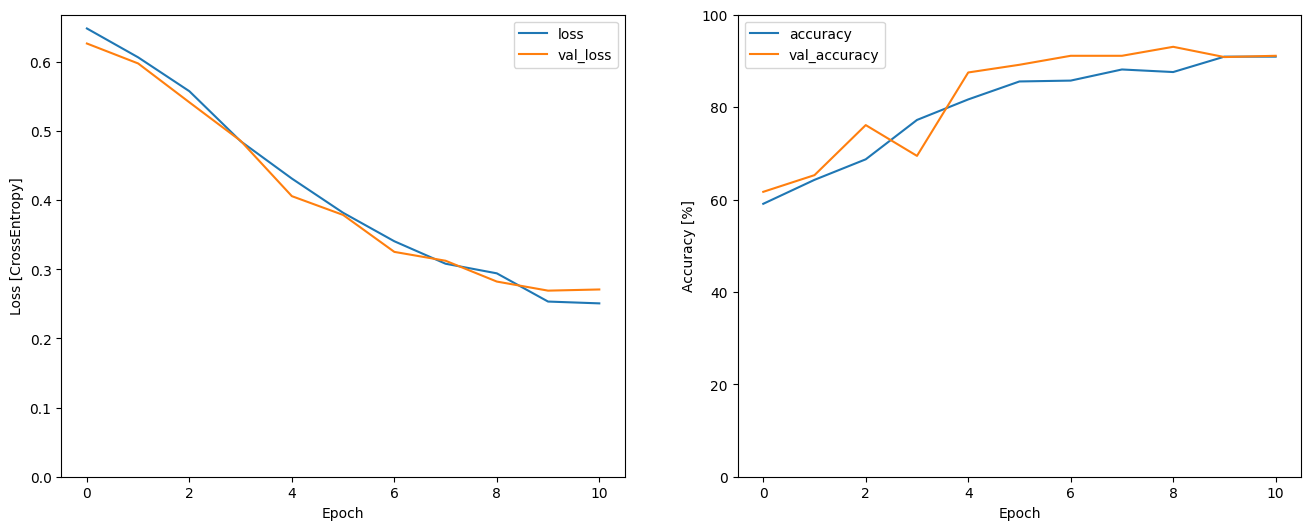

In [24]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Spec] Convolutional model

Epoch 1/20
68/68 [==============================] - 1s 11ms/step - loss: 0.6616 - accuracy: 0.6037 - val_loss: 0.6509 - val_accuracy: 0.6167
Epoch 2/20
68/68 [==============================] - 1s 9ms/step - loss: 0.6314 - accuracy: 0.6315 - val_loss: 0.6268 - val_accuracy: 0.6167
Epoch 3/20
68/68 [==============================] - 1s 9ms/step - loss: 0.6006 - accuracy: 0.6315 - val_loss: 0.5886 - val_accuracy: 0.6167
Epoch 4/20
68/68 [==============================] - 1s 9ms/step - loss: 0.5574 - accuracy: 0.6685 - val_loss: 0.5322 - val_accuracy: 0.7222
Epoch 5/20
68/68 [==============================] - 1s 9ms/step - loss: 0.5115 - accuracy: 0.7537 - val_loss: 0.4858 - val_accuracy: 0.7306
Epoch 6/20
68/68 [==============================] - 1s 9ms/step - loss: 0.4654 - accuracy: 0.7722 - val_loss: 0.4377 - val_accuracy: 0.7972
Epoch 7/20
68/68 [==============================] - 1s 9ms/step - loss: 0.4228 - accuracy: 0.8407 - val_loss: 0.4031 - val_accuracy: 0.8167
Epoch 8/20
68/68 [=

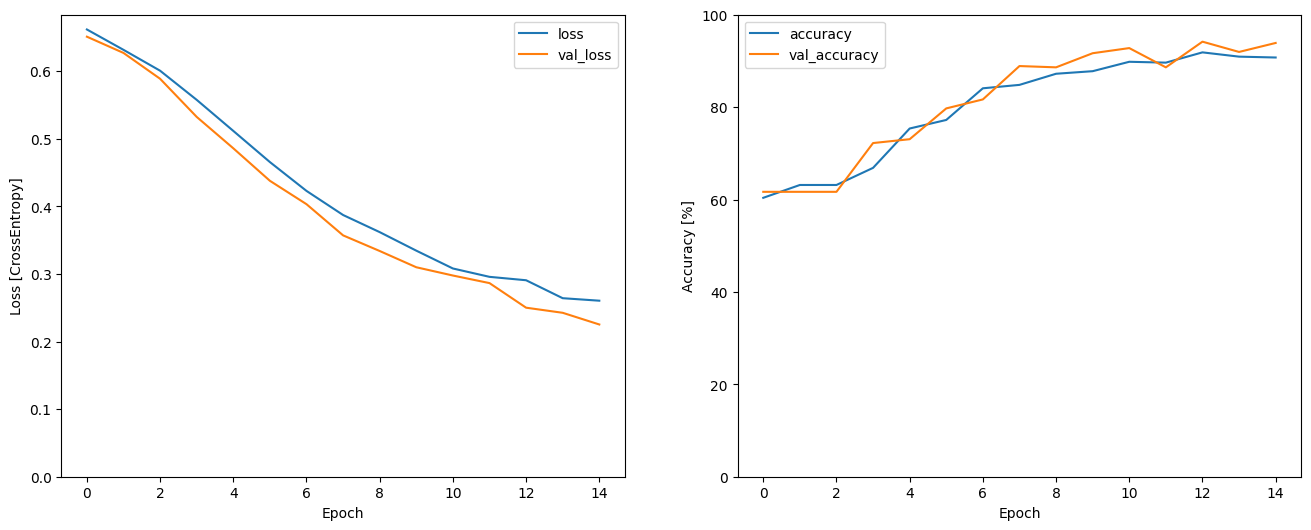

In [25]:
model_spec_conv = get_conv_model_mini(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Save models

In [26]:
model_mfcc_seq.save('models/mfcc_seq.h5')
model_mfcc_conv.save('models/mfcc_conv_mini.h5')
model_spec_seq.save('models/spec_seq.h5')
model_spec_conv.save('models/spec_conv.h5')

In [27]:
history_spec_conv

# Summary

In [28]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f}, Val. Loss: {history.history['val_loss'][-1]:.2f}, Val. Acc: {history.history['val_accuracy'][-1]:.2f}" )

history_to_summary("MFCCs + Sequential model       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv model             ", history_mfcc_conv)
history_to_summary("Spectrogram + Sequential model ", history_spec_seq)
history_to_summary("Spectrogram + Conv model       ", history_spec_conv)


MFCCs + Sequential model       :    Loss: 0.21, Acc: 0.95, Val. Loss: 0.27, Val. Acc: 0.91
MFCCs + Conv model             :    Loss: 0.32, Acc: 0.90, Val. Loss: 0.28, Val. Acc: 0.92
Spectrogram + Sequential model :    Loss: 0.25, Acc: 0.91, Val. Loss: 0.27, Val. Acc: 0.91
Spectrogram + Conv model       :    Loss: 0.26, Acc: 0.91, Val. Loss: 0.23, Val. Acc: 0.94
